# Time Frequency Analysis

Calculate an induced time-frequency analysis of the main experimental contrast Example RQ: What oscillations underlay our effect of interest?

In [1]:
# general purpose
import numpy as np
import pandas as pd

# i/O
from scipy import io
from pathlib import Path
import datetime

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# testing
import unittest

# EEG stuff
import mne
import osfclient 
import mne_bids 
from mne_bids import (BIDSPath, read_raw_bids)

# EEG utils
import ccs_eeg_utils
import ccs_eeg_semesterproject

import configuration

## for one subject

Başar-Eroglu et al. (1992) ([10.1007/s11571-010-9106-0](https://doi.org/10.1016/0167-8760(92)90055-G)) claim that the P3-response is mainly in the delta and theta channels.

- analyse this first only for a pilot subject, then apply the same analysis to all subjects
- first inspect the powerspectrum
- time-frequency plot, with a focus on time or frequency resolution

Reading /home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/Results/epochs/036-epo.fif ...
    Found the data of interest:
        t =    -226.56 ...     773.44 ms
        0 CTF compensation matrices available
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


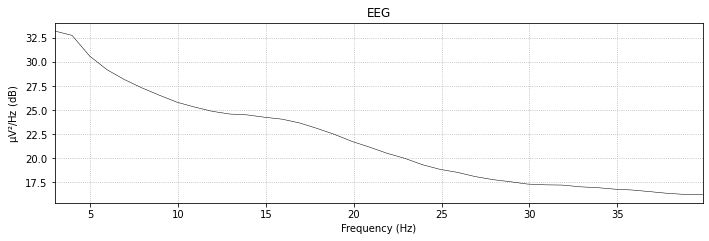

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.5s finished


In [17]:
subject_id = '036'
savepath_epochs_subj = f"{configuration.path_results}/epochs/{subject_id}-epo.fif"

# load epochs from folder
epochs = mne.read_epochs(savepath_epochs_subj)

# frequency analysis
epochs.plot_psd(fmin=2., fmax=40., average=True, spatial_colors=False)

# time-frequency representations
freqs = np.logspace(*np.log10([5, 50]), num=25)
n_cycles = freqs / 2.
power_total = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False,n_jobs=4,average=True)

No baseline correction applied


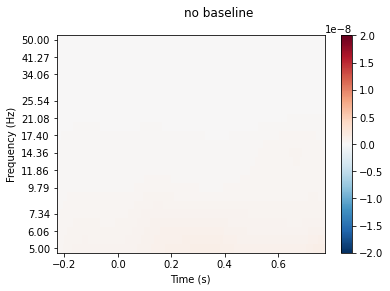

Applying baseline correction (mode: percent)


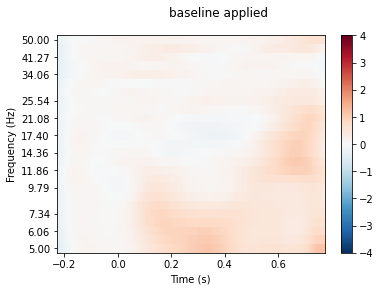

In [20]:
power_total.plot(baseline=None,vmin=-2*10e-9,vmax=2*10e-9,picks=configuration.pick,title='no baseline');
power_total.plot(baseline=[-.5,0],mode='percent',vmin=-4,vmax=4,picks=configuration.pick,title='baseline applied');

I am a bit confused by this result. In the tutorials we did a similar task on `Cz` instead of `Pz` and got pretty different results.

### induced and evoked time-frequency

In [22]:
epochs_induced = epochs.copy()
epochs_induced.subtract_evoked()

power_induced = mne.time_frequency.tfr_morlet(epochs_induced, freqs=freqs, n_cycles=n_cycles, return_itc=False,n_jobs=1,average=True,picks=configuration.pick)
power_induced

Subtracting Evoked from Epochs
[done]


<AverageTFR | time : [-0.226562, 0.773438], freq : [5.000000, 50.000000], nave : 200, channels : 1, ~71 kB>

Applying baseline correction (mode: percent)


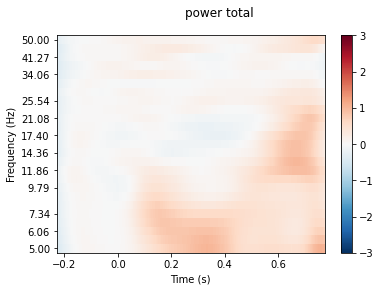

Applying baseline correction (mode: percent)


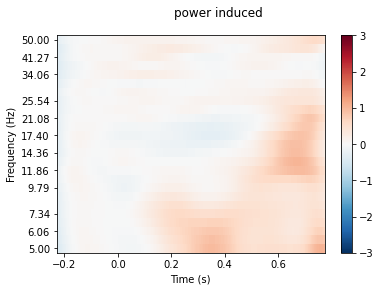

Applying baseline correction (mode: percent)


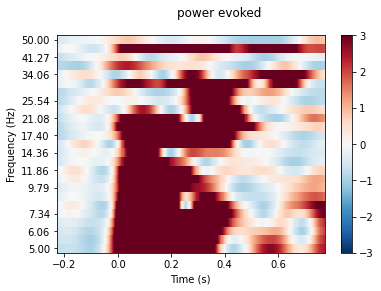

Applying baseline correction (mode: percent)


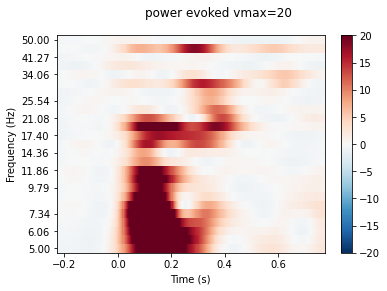

Applying baseline correction (mode: percent)


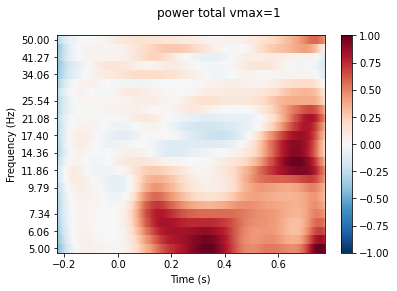

[<Figure size 432x288 with 2 Axes>]

In [25]:
%matplotlib inline
power_evoked = mne.combine_evoked([power_total,power_induced],weights=[1,-1])

mode = "percent"
bsl = [-0.2,0]
cmin = -3
cmax = -cmin
power_total.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=cmin,vmax=cmax,title='power total')
power_induced.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=cmin,vmax=cmax,title='power induced')
power_evoked.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=cmin,vmax=cmax,title='power evoked');
power_evoked.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=-20,vmax=20,title='power evoked vmax=20');
power_total.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=-1,vmax=1,title='power total vmax=1')

## for all subjects

TODO

#####
031
#####
Reading /home/work/Dokumente/Studium/SimTech_MSc/14. Semester/Signal_Processing_and_Analysis_of_Human_Brain_Potentials_EEG/Ostertag_SS2022_EEGSemesterProject/Results/epochs/031-epo.fif ...
    Found the data of interest:
        t =    -226.56 ...     773.44 ms
        0 CTF compensation matrices available
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


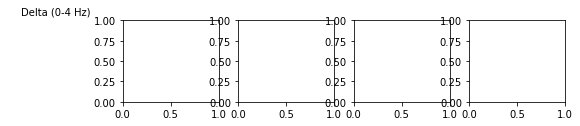

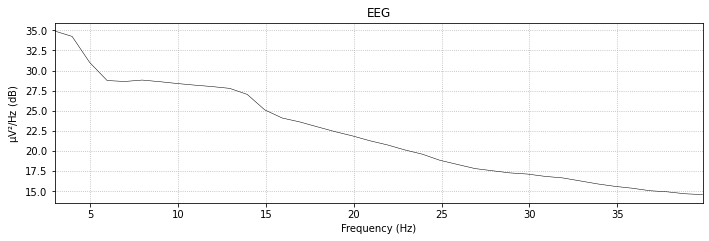

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [3]:
# get epochs:
subject_ids = [path.stem.replace('-epo', '') for path in Path(Path(configuration.path_results, 'epochs')).glob('*-epo.fif')]

for subject in subject_ids:
    print(f"#####\n{subject}\n#####")
    savepath_epochs_subj = f"{configuration.path_results}/epochs/{subject}-epo.fif"

    # load epochs from folder
    epochs = mne.read_epochs(savepath_epochs_subj)

    # frequency analysis
    epochs.plot_psd(fmin=2., fmax=40., average=True, spatial_colors=False)

    # time-frequency representations
    freqs = np.logspace(*np.log10([5, 80]), num=25)
    n_cycles = freqs / 2.
    power_total = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False,n_jobs=4,average=True)

    # visualize all TFs at all electrodes to get an overview

    %matplotlib qt
    power_total.plot_topo(baseline=[-.2,0],mode="logratio",vmin=-2,vmax=2);

    power_total.plot_topo(baseline=[-.2,0],mode='percent',vmin=-4,vmax=4);

    # visualize evoked, total and induced for electrode

    epochs_induced = epochs.copy()
    #epochs_induced._data = epochs_induced._data  - epochs_induced.average().data # but we are using the offocial way here
    epochs_induced.subtract_evoked()

    power_induced = mne.time_frequency.tfr_morlet(epochs_induced, freqs=freqs, n_cycles=n_cycles, return_itc=False,n_jobs=1,average=True,picks=configuration.pick)

    power_induced

    %matplotlib qt
    power_evoked = mne.combine_evoked([power_total,power_induced],weights=[1,-1])

    mode = "percent"
    bsl = [-0.5,0]
    cmin = -3
    cmax = -cmin
    power_total.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=cmin,vmax=cmax)
    power_induced.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=cmin,vmax=cmax)
    power_evoked.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=cmin,vmax=cmax);

    power_evoked.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=-20,vmax=20);

    power_total.plot(baseline=bsl,mode=mode,picks=configuration.pick,vmin=-1,vmax=1)